In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import comptools as comp

color_dict = comp.analysis.get_color_dict()
%matplotlib inline

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Welcome to JupyROOT 6.09/02


In [2]:
df_sim_train, df_sim_test = comp.load_sim(config='IC86.2012')

In [3]:
pipeline_str = 'BDT'
pipeline = comp.get_pipeline(pipeline_str)

In [4]:
feature_list, feature_labels = comp.analysis.get_training_features()

In [5]:
clf_name = pipeline.named_steps['classifier'].__class__.__name__
print('=' * 30)
print(clf_name)
pipeline.fit(df_sim_train[feature_list], df_sim_train['target'])
# pipeline.fit(sim_train.X, sim_train.y, classifier__sample_weight=weights)
train_pred = pipeline.predict(df_sim_train[feature_list])
train_acc = accuracy_score(df_sim_train['target'], train_pred)
print('Training accuracy = {:.2%}'.format(train_acc))
test_pred = pipeline.predict(df_sim_test[feature_list])
test_acc = accuracy_score(df_sim_test['target'], test_pred)
print('Testing accuracy = {:.2%}'.format(test_acc))
print('=' * 30)

GradientBoostingClassifier
Training accuracy = 75.55%
Testing accuracy = 75.34%


In [6]:
df_data = comp.load_data(config='IC86.2012')

/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:137: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])
/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:138: RuntimeWarning: divide by zero encountered in log10
  df['log_d4r_peak_energy'] = np.log10(df['d4r_peak_energy'])
/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:139: RuntimeWarning: divide by zero encountered in log10
  df['log_d4r_peak_sigma'] = np.log10(df['d4r_peak_sigma'])


Plot BDT decision scores

In [7]:
classifier_score = pipeline.decision_function(df_sim_train[feature_list])
light_mask = df_sim_train['MC_comp_class'] == 'light'
heavy_mask = df_sim_train['MC_comp_class'] == 'heavy'

In [8]:
X_data = comp.dataframe_functions.dataframe_to_array(df_data, feature_list + ['lap_log_energy'])
log_energy = X_data[:,-1]
X_data = X_data[:,:-1]
data_score = pipeline.decision_function(X_data)

In [9]:
data_score.min(), data_score.max()

(-2.0974287627808934, 2.1054944386976646)

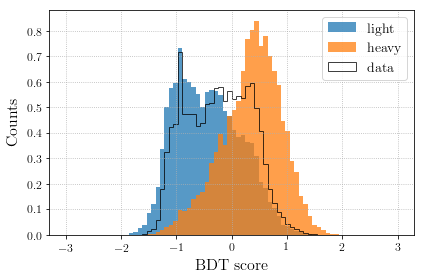

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [10]:
fig, ax = plt.subplots()
score_bins = np.linspace(-3, 3, 75)
ax.hist(classifier_score[light_mask], bins=score_bins, label='light', alpha=0.75, normed=True)
ax.hist(classifier_score[heavy_mask], bins=score_bins, label='heavy', alpha=0.75, normed=True)
ax.hist(data_score, bins=score_bins, label='data', alpha=0.75, color='k', histtype='step', normed=True)
ax.set_xlabel('BDT score')
ax.set_ylabel('Counts')
ax.grid()
ax.legend()
plt.show()

In [17]:
energybins = comp.analysis.get_energybins()

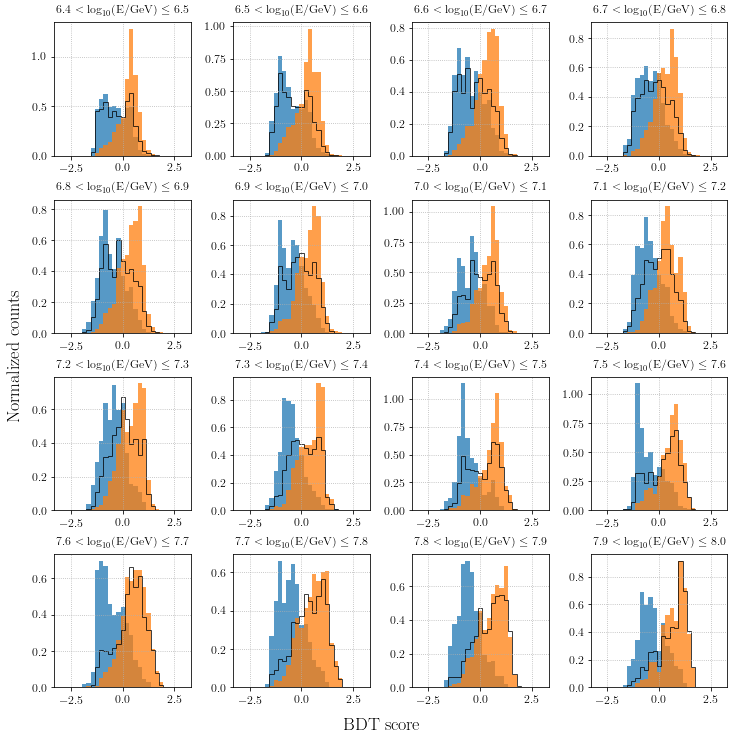

In [49]:
fig, axarr = plt.subplots(4, 4, figsize=(10, 10))
score_bins = np.linspace(-3, 3, 30)

for idx, ax in enumerate(axarr.flatten()):
    # Plot simulation BDT distributions
    sim_energy_mask = (df_sim_train.lap_log_energy > energybins.log_energy_bins[idx]) & \
                      (df_sim_train.lap_log_energy <= energybins.log_energy_bins[idx+1])
    df_sim_bin = df_sim_train[sim_energy_mask]
    classifier_score = pipeline.decision_function(df_sim_bin[feature_list])
    light_mask = df_sim_bin['MC_comp_class'] == 'light'
    heavy_mask = df_sim_bin['MC_comp_class'] == 'heavy'
    ax.hist(classifier_score[light_mask], bins=score_bins, label='light', alpha=0.75, normed=True)
    ax.hist(classifier_score[heavy_mask], bins=score_bins, label='heavy', alpha=0.75, normed=True)

    # Plot data BDT
    data_energy_mask = (log_energy > energybins.log_energy_bins[idx]) & \
                       (log_energy <= energybins.log_energy_bins[idx+1])
    ax.hist(data_score[data_energy_mask], bins=score_bins, label='data', alpha=0.75, color='k',
            histtype='step', normed=True)
    
#     ax.set_xlabel('BDT score')
#     ax.set_ylabel('Counts')
    ax.set_title(str(energybins.log_energy_bins[idx]) + ' $< \mathrm{\log_{10}(E/GeV) \leq}$ ' + str(energybins.log_energy_bins[idx+1]),
                 fontsize=12)
    ax.grid()
#     ax.legend()
fig.text(0.5, -0.02, 'BDT score', ha='center', fontsize=18)
fig.text(-0.02, 0.5, 'Normalized counts', va='center', rotation='vertical', fontsize=18)

plt.tight_layout()
bdt_dist_outfile = os.path.join(comp.paths.figures_dir, 'bdt_score_distributions.png')
plt.savefig(bdt_dist_outfile)
plt.show()